In [1]:
'''
A. Data Engineering
'''

'''
1. Import IMDB Raw Dataset from Auther's gdrive
'''

!pip install --upgrade --no-cache-dir gdown

from IPython.display import clear_output 
clear_output()

# Mini-Imagenet dataset download from Auther's Github repository
import gdown

google_path = 'https://drive.google.com/uc?id='
file_id = '1tqZpPvvyluyu7VVvk99tKpJd4cIkS4yi'
output_name = 'IMDB_Dataset.csv'
gdown.download(google_path+file_id,output_name,quiet=False)
#https://drive.google.com/file/d/1tqZpPvvyluyu7VVvk99tKpJd4cIkS4yi/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1tqZpPvvyluyu7VVvk99tKpJd4cIkS4yi
To: /content/IMDB_Dataset.csv
100%|██████████| 66.2M/66.2M [00:01<00:00, 33.5MB/s]


'IMDB_Dataset.csv'

In [2]:
'''
2. Import Libraries for Data Engineering
'''
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import unicodedata

In [3]:
'''
T. TPU Initialization
'''

import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

print("Tensorflow version {}".format(tf.__version__))
import random
SEED = 1234
tf.random.set_seed(SEED)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU ['10.110.177.2:8470']


REPLICAS: 8
Tensorflow version 2.9.2


In [4]:
'''
3. Tokenizer Install & import
''' 
# Keras Tokenizer is a tokenizer provided by default in tensorflow 2.X and is a word level tokenizer. It does not require a separate installation.

'\n3. Tokenizer Install & import\n'

In [5]:
'''
4. Load and modifiy to pandas dataframe
'''
import pandas as pd

pd.set_option('display.max_colwidth', 100)
# pd.set_option('display.max_colwidth', None)

dataset_df = pd.read_csv('/content/IMDB_Dataset.csv')

print(len(dataset_df))

dataset_df.head()

dataset_df.rename(columns = {'review':'SRC', 'sentiment':'TRG'}, inplace = True)
dataset_df.head()

dataset_df['TRG'] = dataset_df['TRG'].str.replace('positive','1')
dataset_df['TRG'] = dataset_df['TRG'].str.replace('negative','0')
dataset_df.head()

dataset_df['TRG'] = dataset_df['TRG'].astype(int)

TRG_df = dataset_df["TRG"].to_numpy()

print(TRG_df[:10])

len(TRG_df)

50000
[1 1 1 0 1 1 1 0 0 1]


50000

In [6]:
'''
5. Preprocess and build list
'''
raw_src = []
for sentence in dataset_df['SRC']:
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    raw_src.append(sentence)

print(raw_src[:10])

['one of the other reviewers has mentioned that after watching just oz episode you will be hooked . they are right , as this is exactly what happened with me . br br the first thing that struck me about oz was its brutality and unflinching scenes of violence , which set in right from the word go . trust me , this is not a show for the faint hearted or timid . this show pulls no punches with regards to drugs , sex or violence . its is hardcore , in the classic use of the word . br br it is called oz as that is the nickname given to the oswald maximum security state penitentary . it focuses mainly on emerald city , an experimental section of the prison where all the cells have glass fronts and face inwards , so privacy is not high on the agenda . em city is home to many . . aryans , muslims , gangstas , latinos , christians , italians , irish and more . . . . so scuffles , death stares , dodgy dealings and shady agreements are never far away . br br i would say the main appeal of the sho

In [7]:
'''
6. Tokenizer and Vocab define
'''
SRC_df = pd.DataFrame(raw_src)

SRC_df.rename(columns={0: "SRC"}, errors="raise", inplace=True)

raw_src_df  = SRC_df['SRC']

print(raw_src_df[:10])

src_sentence  = raw_src_df.apply(lambda x: "<SOS> " + str(x))

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Define tokenizer
SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)

SRC_tokenizer.fit_on_texts(src_sentence)

vocab_size = len(SRC_tokenizer.word_index) + 1

print('Encoder 단어 집합의 크기 :',vocab_size)

0    one of the other reviewers has mentioned that after watching just oz episode you will be hooked ...
1    a wonderful little production . br br the filming technique is very unassuming very old time bbc...
2    i thought this was a wonderful way to spend time on a too hot summer weekend , sitting in the ai...
3    basically there s a family where a little boy jake thinks there s a zombie in his closet his par...
4    petter mattei s love in the time of money is a visually stunning film to watch . mr . mattei off...
5    probably my all time favorite movie , a story of selflessness , sacrifice and dedication to a no...
6    i sure would like to see a resurrection of a up dated seahunt series with the tech they have tod...
7    this show was an amazing , fresh innovative idea in the s when it first aired . the first or yea...
8    encouraged by the positive comments about this film on here i was looking forward to watching th...
9    if you like original gut wrenching laughter you wi

In [8]:
'''
7. Tokenizer test
'''
lines = [
  "It is winter and the weather is very cold.",
  "Will this Christmas be a white Christmas?",
  "Be careful not to catch a cold in winter and have a happy new year."
]
for line in lines:
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])
    ids_2_txt = SRC_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

Input     : It is winter and the weather is very cold.
txt_2_ids : [[9, 6, 3623, 3, 2, 5476, 6, 56, 1036]]
ids_2_txt : it is winter and the weather is very cold 

Input     : Will this Christmas be a white Christmas?
txt_2_ids : [[59, 12, 1116, 30, 4, 435, 1116]]
ids_2_txt : will this christmas be a white christmas 

Input     : Be careful not to catch a cold in winter and have a happy new year.
txt_2_ids : [[30, 4359, 14, 7, 1273, 4, 1036, 10, 3623, 3, 26, 4, 646, 166, 285]]
ids_2_txt : be careful not to catch a cold in winter and have a happy new year 



In [9]:
'''
8. Tokenize  
''' 
# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
tokenized_inputs  = SRC_tokenizer.texts_to_sequences(src_sentence)

Maximum length of review : 2512
Average length of review : 238.89044


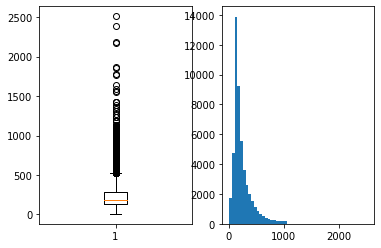

In [10]:
'''
9. Explore the tokenized datasets.
'''
len_result = [len(s) for s in tokenized_inputs]

print('Maximum length of review : {}'.format(np.max(len_result)))
print('Average length of review : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [11]:
'''
10. Pad sequences
'''

from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 300
tkn_sources = pad_sequences(tokenized_inputs,  maxlen=max_len, padding='post', truncating='post')

'''
11. Data type define
'''
tkn_sources = tf.cast(tkn_sources, dtype=tf.int64)

In [12]:
'''
12. Split Data
'''
print('질문 데이터의 크기(shape) :', tkn_sources.shape)

# 0번째 샘플을 임의로 출력
print(tkn_sources[0])

X_train = tkn_sources[:25000]
y_train = TRG_df[:25000]
X_valid = tkn_sources[25000:45000]
y_valid = TRG_df[25000:45000]
X_test  = tkn_sources[45000:]
y_test  = TRG_df[45000:]

print('Number of minibatch for training dataset   : {}'.format(len(X_train)))
print('Number of minibatch for validation dataset : {}'.format(len(X_valid)))
print('Number of minibatch for testing dataset    : {}'.format(len(X_test)))

질문 데이터의 크기(shape) : (50000, 300)
tf.Tensor(
[   31    29     5     2    84  2024    49  1040    13   104   149    43
  3040   385    23    59    30  3152    34    25   201    16    12     6
   603    52   582    19    73     8     8     2    92   148    13  3194
    73    47  3040    15    95  5308     3 14833   137     5   550    64
   259    10   201    39     2   637   142  1710    73    12     6    14
     4   120    18     2  7774  2288    42 11297    12   120  2553    60
  5826    19  5424     7  1445   363    42   550    95     6  3766    10
     2   348   350     5     2   637     8     8     9     6   422  3040
    16    13     6     2 11466   351     7     2 14548  6717  2500  1022
 50891     9  2674  1390    24 22758   509    36  4589  2414     5     2
  1175   119    32     2  6898    26  2868 11779     3   377 50892    38
 16345     6    14   290    24     2  4812  2869   509     6   332     7
   111 24493  8037 39614 14549  4972  7662  2402     3    55    38 44173
   317 

In [13]:
'''
B. Model Engineering
'''

'''
M1. Import Libraries for Model Engineering
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model

In [14]:
'''
M2. Set Hyperparameters
'''
embedding_dim = 256
hidden_units = 128
EPOCHS = 20
learning_rate = 5e-4

In [15]:
# initialize and compile model within strategy scope
with strategy.scope():
    '''
    M3. Build NN model
    '''
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    '''
    M4. Optimizer
    '''
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    '''
    M5. Model Compilation - model.compile
    '''
    # model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         26001408  
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 26,198,657
Trainable params: 26,198,657
Non-trainable params: 0
_________________________________________________________________


In [16]:
'''
M6. EarlyStopping
'''
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)

In [17]:
'''
M7. ModelCheckpoint
'''
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [18]:
'''
M8. Train and Validation - `model.fit`
'''
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_valid, y_valid), callbacks=[es, mc])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5565
Epoch 1: val_accuracy improved from -inf to 0.62530, saving model to best_model.h5
782/782 [==============================] - 80s 89ms/step - loss: 0.6814 - accuracy: 0.5565 - val_loss: 0.6640 - val_accuracy: 0.6253
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.5735
Epoch 2: val_accuracy improved from 0.62530 to 0.65630, saving model to best_model.h5
782/782 [==============================] - 64s 82ms/step - loss: 0.6732 - accuracy: 0.5735 - val_loss: 0.6364 - val_accuracy: 0.6563
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.5997
Epoch 3: val_accuracy did not improve from 0.65630
782/782 [==============================] - 63s 80ms/step - loss: 0.6363 - accuracy: 0.5997 - val_loss: 0.6544 - val_accuracy: 0.6336
Epoch 4/20
782/782 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.68

In [19]:
'''
M9. Assess model performance
'''
loaded_model = load_model('best_model.h5')
print("\n Test Accuracy: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

157/157 [==============================] - 10s 59ms/step - loss: 0.3575 - accuracy: 0.8742

 Test Accuracy: 0.8742


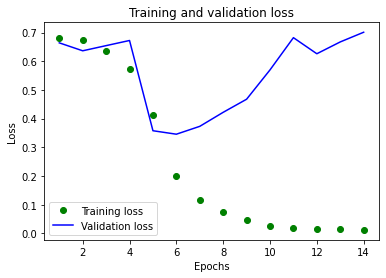

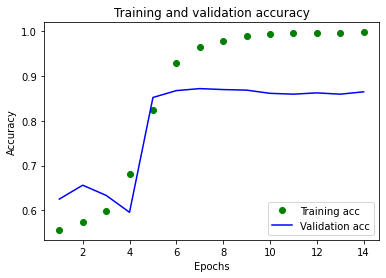

In [20]:
'''
M10. [Opt] Plot Loss and Accuracy
'''
history_dict = history.history
history_dict.keys()

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'o', color='g', label='Training loss')   # 'bo'
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'o', color='g', label='Training acc')   # 'bo'
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [21]:
'''
M11. [Opt] Training result test for Code Engineering
'''
def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

    txt_2_ids = SRC_tokenizer.texts_to_sequences([new_sentence])

    pad_sequence = pad_sequences(txt_2_ids, maxlen=max_len) # 패딩
    score = float(loaded_model.predict(pad_sequence)) # 예측

    if(score > 0.5):
        print("A positive review with a {:.2f}% chance. ".format(score * 100))
    else:
        print("A negative review with a {:.2f}% chance. ".format((1 - score) * 100))

for idx in range(10):
    print('----'*30)
    test_input = src_sentence[45000+idx]
    print("Test sentence from datasets:\n", test_input)
    sentiment_predict(test_input)
    if(y_test[idx] > 0.5):
        print("Ground truth is positive!")
    else:
        print("Ground truth is negative!")

------------------------------------------------------------------------------------------------------------------------
Test sentence from datasets:
 <SOS> what i enjoyed most in this film was the scenery of corfu , being greek i adore my country and i liked the flattering director s point of view . based on a true story during the years when greece was struggling to stand on her own two feet through war , nazis and hardship . an italian soldier and a greek girl fall in love but the times are hard and they have a lot of sacrifices to make . nicholas cage looking great in a uniform gives a passionate account of this unfulfilled in the beginning love . i adored christian bale playing mandras the heroine s husband to be , he looks very very good as a greek , his personality matched the one of the greek patriot ! a true fighter in there , or what ! one of the movies i would like to buy and keep it in my collection . . . for ever !
1/1 [==============================] - 0s 343ms/step
A neg